<a href="https://colab.research.google.com/github/zeepaulus/Spam-Ham-Detection/blob/main/Spam-Ham-Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT LIBRARIES

In [1]:
# Standard Python libraries
import re
import string
from collections import Counter, defaultdict

# Third-party libraries for data processing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLTK libraries for text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Download required NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Exploratory Data Analysis

*   Checking for Missing Values
*   



In [2]:
def format_data(filename: str) -> pd.DataFrame:
    """
    Read a CSV file, combine Subject and Message into a single text column,
    and calculate punctuation ratios.

    Args:
        filename (str): Path to the CSV file.

    Returns:
        pd.DataFrame: DataFrame with 'text', 'label', and punctuation ratios.
    """
    df = pd.read_csv(filename, encoding='utf-8')

    required_columns = ['Subject', 'Message', 'Spam/Ham']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")

    df = df.copy()
    df['Subject'] = df['Subject'].fillna('')
    df['Message'] = df['Message'].fillna('')

    # Combine Subject and Message into text
    df['text'] = df['Subject'] + ' ' + df['Message']

    # Calculate punctuation ratios
    df['dot_ratio'] = df['text'].apply(
        lambda x: len(re.findall(r'\.', x)) / max(len(x), 1))
    df['comma_ratio'] = df['text'].apply(
        lambda x: len(re.findall(r',', x)) / max(len(x), 1))
    df['exclamation_ratio'] = df['text'].apply(
        lambda x: len(re.findall(r'!', x)) / max(len(x), 1))
    df['question_ratio'] = df['text'].apply(
        lambda x: len(re.findall(r'\?', x)) / max(len(x), 1))

    valid_labels = {'spam', 'ham'}
    invalid_labels = set(df['Spam/Ham']) - valid_labels
    if invalid_labels:
        raise ValueError(f"Invalid labels found: {invalid_labels}. Expected 'spam' or 'ham'.")

    result_df = df[['text', 'Spam/Ham', 'dot_ratio', 'comma_ratio',
                    'exclamation_ratio', 'question_ratio']]
    print(f"Formatted {len(result_df)} emails from {filename}")
    return result_df

In [3]:
df = format_data('/content/train.csv')

Formatted 27284 emails from /content/train.csv


In [4]:
df.head()

,text,Spam/Ham,dot_ratio,comma_ratio,exclamation_ratio,question_ratio
0,christmas tree farm pictures,ham,0.000000,0.000000,0.0,0.000000
1,"vastar resources , inc . gary , production fro...",ham,0.005108,0.012306,0.0,0.000232
2,calpine daily gas nomination - calpine daily g...,ham,0.014925,0.000000,0.0,0.000000
3,re : issue fyi - see note below - already done...,ham,0.005922,0.004230,0.0,0.000000
4,"mcmullen gas for 11 / 99 jackie ,\nsince the i...",ham,0.005367,0.016100,0.0,0.003578


In [5]:
# General Information
print("=== DATASET INFORMATION ===")
print(f"Total number of emails: {len(df)}")
print(f"Number of columns: {len(df.columns)}")
print(f"Columns: {df.columns.tolist()}")
print(f"Dataset shape: {df.shape}")

# Check for Missing Data
print("\n=== MISSING DATA ===")
missing_data = df.isnull().sum()
print(missing_data)
print(f"Percentage of missing data: {(missing_data.sum() / len(df)) * 100:.2f}%")

=== DATASET INFORMATION ===
Total number of emails: 27284
Number of columns: 6
Columns: ['text', 'Spam/Ham', 'dot_ratio', 'comma_ratio', 'exclamation_ratio', 'question_ratio']
Dataset shape: (27284, 6)

=== MISSING DATA ===
text                 0
Spam/Ham             0
dot_ratio            0
comma_ratio          0
exclamation_ratio    0
question_ratio       0
dtype: int64
Percentage of missing data: 0.00%


=== SPAM/HAM DISTRIBUTION ===
Spam/Ham
spam    13858
ham     13426
Name: count, dtype: int64
Spam percentage: 50.79%
Ham percentage: 49.21%


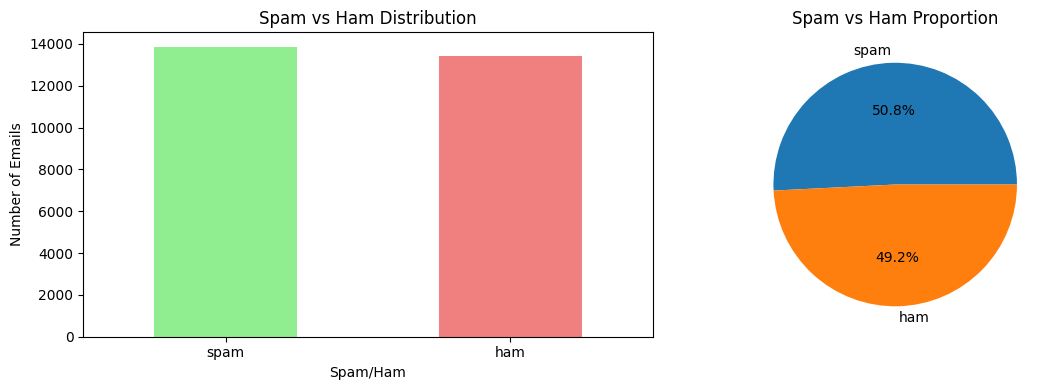

In [6]:
# Count Spam vs Ham
print("=== SPAM/HAM DISTRIBUTION ===")
label_counts = df['Spam/Ham'].value_counts()
print(label_counts)
print(f"Spam percentage: {label_counts['spam'] / len(df) * 100:.2f}%")
print(f"Ham percentage: {label_counts['ham'] / len(df) * 100:.2f}%")

# Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
label_counts.plot(kind='bar', color=['lightgreen', 'lightcoral'])
plt.title('Spam vs Ham Distribution')
plt.ylabel('Number of Emails')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Spam vs Ham Proportion')

plt.tight_layout()
plt.show()

In [7]:
def get_word_frequency(df: pd.DataFrame, label: str) -> Counter:
    """
    Calculate word frequency for emails with a given label, using text column.

    Args:
        df (pd.DataFrame): DataFrame with 'text' and 'label' columns.
        label (str): Label of the emails ('spam' or 'ham').

    Returns:
        Counter: Word frequencies (words longer than 2 characters, no stopwords).
    """
    stop_words = set(stopwords.words('english'))
    all_words = []
    texts = df[df['Spam/Ham'] == label]['text']
    for text in texts:
        text = re.sub(r'http\S+|www\S+|\d+', ' ', str(text).lower())
        words = text.split()
        all_words.extend([word for word in words if len(word) > 2 and word not in stop_words])
    return Counter(all_words)

# Analyze words in spam vs ham emails
spam_texts = df[df['Spam/Ham'] == 'spam']['text']
ham_texts = df[df['Spam/Ham'] == 'ham']['text']

spam_words = get_word_frequency(df, 'spam')
ham_words = get_word_frequency(df, 'ham')

print("=== TOP 20 MOST COMMON WORDS ===")
print("\nIn SPAM emails:")
for word, freq in spam_words.most_common(20):
    print(f"{word}: {freq}")

print("\nIn HAM emails:")
for word, freq in ham_words.most_common(20):
    print(f"{word}: {freq}")

=== TOP 20 MOST COMMON WORDS ===

In SPAM emails:
com: 9307
company: 9001
http: 7069
information: 6283
email: 6241
please: 5909
statements: 5327
may: 5020
one: 4828
get: 4809
money: 4501
time: 4456
business: 4401
new: 4334
www: 4284
price: 3864
mail: 3838
within: 3774
free: 3765
report: 3558

In HAM emails:
enron: 37033
ect: 28512
hou: 13647
please: 10526
subject: 9816
com: 9783
would: 8425
vince: 7022
gas: 6464
new: 6218
thanks: 5863
energy: 5764
know: 5451
power: 5052
time: 4967
message: 4929
may: 4891
company: 4891
corp: 4855
deal: 4459


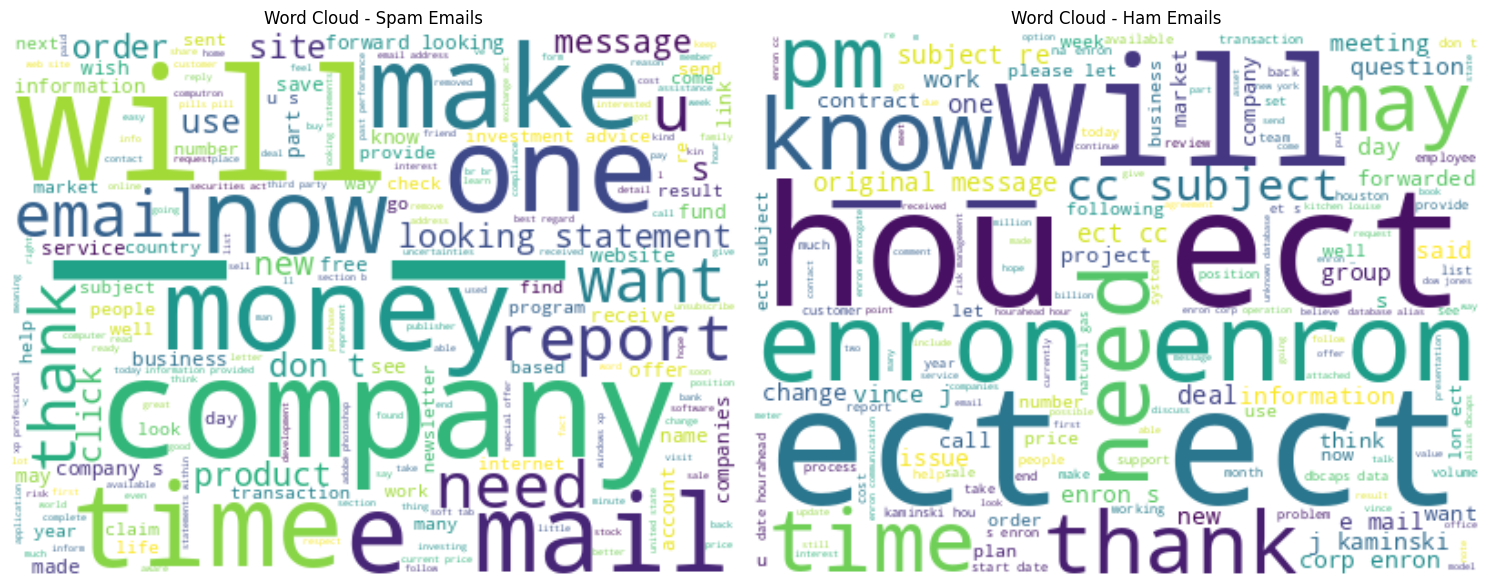

In [8]:
plt.figure(figsize=(15, 6))

# Word cloud for spam
spam_text = ' '.join(spam_texts.astype(str))
spam_wordcloud = WordCloud(width=400, height=300, background_color='white').generate(spam_text)
plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud - Spam Emails')
plt.axis('off')

# Word cloud for ham
ham_text = ' '.join(ham_texts.astype(str))
ham_wordcloud = WordCloud(width=400, height=300, background_color='white').generate(ham_text)
plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Word Cloud - Ham Emails')
plt.axis('off')

plt.tight_layout()
plt.show()

# Data format

This section formats the Enron-Spam dataset by combining `Subject` and `Message` into a single text field, cleaning special characters, and preparing data for preprocessing. The `format_data` function:
- Takes a pandas DataFrame as input.
- Combines `Subject` and `Message`, excluding ID columns.
- Removes EOF (\x1A), control characters, and normalizes whitespace.
- Handles missing values and duplicates.
- Returns a list of `(combined_text, label)` tuples for further preprocessing.


In [9]:
def process_email(text):
    """
    Preprocess email text: lowercase, remove HTML tags, normalize numbers/emails/URLs,
    apply stemming, remove stop words and punctuation.
    - text: Input email text (subject + message).
    - Returns: List of processed words.
    """
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[0-9]+', 'num', text)
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', 'emailaddr', text)
    text = re.sub(r'(http|https)://[^\s]*', 'url', text)
    text = re.sub(r'[$]+', 'dollar', text)
    words = word_tokenize(text)
    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    words = [
        ps.stem(re.sub(r'[^a-zA-Z0-9]', '', word))
        for word in words
        if len(word) >= 1 and word not in stop_words and word not in string.punctuation
    ]
    words = [word for word in words if word]
    return words

In [10]:
def clean_data(df):
    """
    Preprocess a DataFrame of emails using process_email and return a DataFrame.
    - df: DataFrame with 'text', and 'Spam/Ham' columns.
    - Returns: DataFrame with a new 'Processed_Text' column containing processed words.
    """
    # Copy DataFrame to avoid modifying the original
    df = df.copy()

    # Apply process_email
    df['cleaned_text'] = df['text'].apply(process_email)
    return df
df = clean_data(df)

# Preproessing

In [11]:
def text_to_vector(text, word_to_idx):
    """
    Convert text to feature vector.
    - text: List of processed words or string to be processed.
    - word_to_idx: Dictionary mapping words to feature indices.
    - Returns: Feature vector (numpy array).
    """
    if isinstance(text, str):
        words = process_email(text)
    else:
        words = text
    vector = np.zeros(len(word_to_idx))
    for word in words:
        if word in word_to_idx:
            vector[word_to_idx[word]] += 1
    return vector

# Create vocabulary from TRAINING DATA ONLY
print("=== CREATING VOCABULARY FROM TRAINING DATA ===")
all_words = []
for words in df['cleaned_text']:
    all_words.extend(words)

word_freq = Counter(all_words)
print(f"Total words in training corpus: {len(all_words):,}")
print(f"Unique words: {len(word_freq):,}")

# Create vocabulary with filtering
min_freq = 2  # Words must appear at least 2 times
max_vocab = 5000  # Maximum vocabulary size of 5000 words
vocabulary = [word for word, freq in word_freq.most_common() if freq >= min_freq][:max_vocab]
word_to_idx = {word: idx for idx, word in enumerate(vocabulary)}

print(f"Final vocabulary size: {len(vocabulary):,}")
print(f"Top 20 words: {vocabulary[:20]}")

# Convert to feature vectors
print("\n=== CONVERTING TO FEATURE VECTORS ===")
X_train = np.array([text_to_vector(words, word_to_idx) for words in df['cleaned_text']])
y_train = df['Spam/Ham'].map({'spam': 1, 'ham': 0}).values

print(f"FEATURE ENGINEERING COMPLETED")
print(f"Training data: X_train {X_train.shape}, y_train {y_train.shape}")

# Statistics
print(f"\n=== STATISTICS ===")
print(f"Training set - Spam: {np.sum(y_train)} ({np.mean(y_train)*100:.1f}%)")
print(f"Average words per email - Train: {np.mean(np.sum(X_train, axis=1)):.1f}")

=== CREATING VOCABULARY FROM TRAINING DATA ===
Total words in training corpus: 3,925,761
Unique words: 104,772
Final vocabulary size: 5,000
Top 20 words: ['num', 'enron', 'dollar', 'ect', 'com', 'compani', 'pleas', 'hou', 'e', 'inform', 'subject', 'price', 'time', 'would', 'new', 'market', 'get', 'may', 'thank', 'need']

=== CONVERTING TO FEATURE VECTORS ===
FEATURE ENGINEERING COMPLETED
Training data: X_train (27284, 5000), y_train (27284,)

=== STATISTICS ===
Training set - Spam: 13858 (50.8%)
Average words per email - Train: 125.7


# TRAIN

In [12]:
class NaiveBayesClassifier:
    def __init__(self, alpha=1.0):
        """
        Initialize the Multinomial Naïve Bayes Classifier.
        - alpha: Laplace smoothing parameter.
        """
        self.alpha = alpha
        self.priors = {}  # Prior probabilities P(class)
        self.likelihoods = {}  # Conditional probabilities P(feature | class)
        self.classes = None  # List of classes

    def fit(self, X, y):
        """
        Train the model.
        - X: Feature matrix (n_samples, n_features).
        - y: Class labels (n_samples,).
        """
        self.classes = np.unique(y)
        n_samples, n_features = X.shape

        # Calculate prior probabilities P(class)
        for c in self.classes:
            self.priors[c] = np.sum(y == c) / n_samples

        # Calculate conditional probabilities P(feature | class) with Laplace smoothing
        for c in self.classes:
            X_c = X[y == c]  # Data for class c
            total_counts = np.sum(X_c)  # Total feature counts in class c
            vocab_size = n_features  # Vocabulary size
            # Compute likelihood with Laplace smoothing
            self.likelihoods[c] = (np.sum(X_c, axis=0) + self.alpha) / (total_counts + self.alpha * vocab_size)

    def predict_proba(self, X):
        """
        Predict probabilities for each class.
        - X: Feature matrix (n_samples, n_features).
        - Returns: Probability matrix (n_samples, n_classes).
        """
        n_samples = X.shape[0]
        probs = np.zeros((n_samples, len(self.classes)))

        for i, c in enumerate(self.classes):
            # Start with log of prior probability
            log_prob = np.log(self.priors[c])
            # Multinomial: compute log P(x | class) = sum(log P(feature | class) * x)
            log_likelihood = np.sum(np.log(self.likelihoods[c]) * X, axis=1)
            probs[:, i] = log_prob + log_likelihood

        # Normalize probabilities (softmax)
        probs = np.exp(probs - np.max(probs, axis=1, keepdims=True))  # Avoid overflow
        probs /= np.sum(probs, axis=1, keepdims=True)
        return probs

    def predict(self, X):
        """
        Predict class labels for data.
        - X: Feature matrix (n_samples, n_features).
        - Returns: Predicted class labels (n_samples,).
        """
        probs = self.predict_proba(X)
        return self.classes[np.argmax(probs, axis=1)]

    def evaluate(self, X, y):
        """
        Evaluate the model with accuracy, precision, recall, and F1 score.
        - X: Feature matrix (n_samples, n_features).
        - y: True labels (n_samples,).
        - Returns: Prints evaluation metrics.
        """
        y_pred = self.predict(X)
        n_samples = len(y)

        # Calculate accuracy
        accuracy = np.sum(y_pred == y) / n_samples

        # Calculate precision, recall, F1 score per class and weighted average
        precision = {}
        recall = {}
        f1_score = {}
        class_counts = Counter(y)

        for c in self.classes:
            true_positive = np.sum((y_pred == c) & (y == c))
            false_positive = np.sum((y_pred == c) & (y != c))
            false_negative = np.sum((y_pred != c) & (y == c))

            # Precision: TP / (TP + FP)
            precision[c] = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
            # Recall: TP / (TP + FN)
            recall[c] = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
            # F1 score: 2 * (precision * recall) / (precision + recall)
            f1_score[c] = (2 * precision[c] * recall[c]) / (precision[c] + recall[c]) if (precision[c] + recall[c]) > 0 else 0

        # Calculate weighted averages
        weighted_precision = sum(precision[c] * class_counts[c] for c in self.classes) / n_samples
        weighted_recall = sum(recall[c] * class_counts[c] for c in self.classes) / n_samples
        weighted_f1 = sum(f1_score[c] * class_counts[c] for c in self.classes) / n_samples

        # Print results
        print(f"Accuracy: {accuracy:.4f}")
        print("Per-class metrics:")
        for c in self.classes:
            print(f"Class {c}: Precision={precision[c]:.4f}, Recall={recall[c]:.4f}, F1 Score={f1_score[c]:.4f}")
        print(f"Weighted Precision: {weighted_precision:.4f}")
        print(f"Weighted Recall: {weighted_recall:.4f}")
        print(f"Weighted F1 Score: {weighted_f1:.4f}")

# Training model
model = NaiveBayesClassifier()
model.fit(X_train, y_train)
model.evaluate(X_train, y_train)

Accuracy: 0.9783
Per-class metrics:
Class 0: Precision=0.9780, Recall=0.9779, F1 Score=0.9779
Class 1: Precision=0.9786, Recall=0.9786, F1 Score=0.9786
Weighted Precision: 0.9783
Weighted Recall: 0.9783
Weighted F1 Score: 0.9783


# Function

In [15]:
def function_1_predict_new_email(model, word_to_idx, class_names=None):
    """
    Function 1: Take new email input from user and predict SPAM/HAM (or other classes).
    - model: Trained NaiveBayesClassifier instance.
    - word_to_idx: Dictionary mapping words to feature indices.
    - class_names: Optional dictionary mapping class indices to names (e.g., {0: 'HAM', 1: 'SPAM'}).
    """
    print("=" * 60)
    print("FUNCTION 1: PREDICT NEW EMAIL")
    print("=" * 60)

    # Default class names if not provided
    if class_names is None:
        class_names = {0: 'HAM', 1: 'SPAM'}

    while True:
        print("\n--- Enter new email details ---")

        # Get user input
        subject = input("Enter email Subject: ").strip()
        message = input("Enter email Message: ").strip()

        if not subject and not message:
            print("Both Subject and Message are empty! Please enter at least one.")
            continue

        try:
            # Preprocess email using process_email
            combined_text = subject + ' ' + message
            processed_words = process_email(combined_text)
            processed_text = ' '.join(processed_words)

            # Convert to feature vector
            vector = text_to_vector(processed_words, word_to_idx)

            # Check if vector is all zeros (no words match vocabulary)
            if np.sum(vector) == 0:
                print("No words in the email match the vocabulary. Cannot predict accurately.")
                continue

            # Ensure vector is a 2D numpy array for prediction
            vector = np.asarray(vector).reshape(1, -1)

            # Predict
            prediction = model.predict(vector)[0]
            probabilities = model.predict_proba(vector)[0]

            # Map prediction to class name
            result = class_names.get(prediction, str(prediction))
            confidence = probabilities[np.where(model.classes == prediction)[0][0]]

            # Display results
            print("\n" + "=" * 50)
            print("PREDICTION RESULTS")
            print("=" * 50)
            print(f"Subject: {subject}")
            print(f"Message: {message}")
            print(f"Processed: {processed_text[:100]}{'...' if len(processed_text) > 100 else ''}")
            print(f"\nPREDICTION: {result}")
            print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
            print(f"Detailed Probabilities:")
            for i, c in enumerate(model.classes):
                print(f"   - {class_names.get(c, str(c))}: {probabilities[i]:.4f} ({probabilities[i]*100:.2f}%)")

            # Display key words
            print(f"\nKey words found:")
            important_words = [word for word in processed_words if word in word_to_idx][:10]
            print(f"   {', '.join(important_words) if important_words else 'No key words in vocabulary'}")

        except Exception as e:
            print(f"Processing error: {e}")

        # Ask to continue
        continue_choice = input("\nWould you like to predict another email? (y/n): ").lower()
        if continue_choice != 'y':
            break

    print("Function 1 completed!")

function_1_predict_new_email(model, word_to_idx)

FUNCTION 1: PREDICT NEW EMAIL

--- Enter new email details ---
Enter email Subject: Hi sir
Enter email Message: Can I have a look at your bank account?

PREDICTION RESULTS
Subject: Hi sir
Message: Can I have a look at your bank account?
Processed: hi sir look bank account

PREDICTION: SPAM
Confidence: 0.9971 (99.71%)
Detailed Probabilities:
   - HAM: 0.0029 (0.29%)
   - SPAM: 0.9971 (99.71%)

Key words found:
   hi, sir, look, bank, account

Would you like to predict another email? (y/n): n
Function 1 completed!


In [18]:
def function_2_evaluate_csv_file(model, word_to_idx):
    """
    Function 2: Read a CSV file with similar structure and evaluate the model.
    - model: Trained NaiveBayesClassifier instance.
    - word_to_idx: Dictionary mapping words to feature indices.
    """
    print("=" * 60)
    print("FUNCTION 2: EVALUATE CSV FILE")
    print("=" * 60)

    # Input filename
    filename = input("\nEnter CSV filename (e.g., test.csv): ").strip()

    if not filename:
        print("Please enter a filename!")
        return

    try:
        # Read CSV file
        print(f"\nReading file: {filename}")
        test_df = pd.read_csv(filename, encoding='utf-8')

        print(f"File read successfully!")
        print(f"File size: {test_df.shape}")
        print(f"Columns: {test_df.columns.tolist()}")

        # Check file structure
        required_columns = ['Subject', 'Message', 'Spam/Ham']
        missing_columns = [col for col in required_columns if col not in test_df.columns]

        if missing_columns:
            print(f"File missing columns: {missing_columns}")
            print(f"Required structure: Subject, Message, Spam/Ham")
            return

        # Clean test data
        print(f"\nCleaning data...")
        test_df = format_data(filename)
        test_clean = clean_data(test_df)

        if len(test_clean) == 0:
            print("No valid data after cleaning!")
            return

        # Convert to feature vectors
        print(f"Converting to feature vectors...")
        X_test = np.array([text_to_vector(text, word_to_idx) for text in test_clean['cleaned_text']])
        y_test = np.array(test_clean['Spam/Ham'].map({'spam': 1, 'ham': 0}))

        # Evaluate using model's evaluate method
        print(f"\nEvaluating model...")
        class_names = {0: 'HAM', 1: 'SPAM'}
        model.evaluate(X_test, y_test)

        # Predict
        print(f"Performing predictions...")
        y_pred_test = model.predict(X_test)
        y_proba_test = model.predict_proba(X_test)

        # Calculate confusion matrix
        tp = np.sum((y_test == 1) & (y_pred_test == 1))
        tn = np.sum((y_test == 0) & (y_pred_test == 0))
        fp = np.sum((y_test == 0) & (y_pred_test == 1))
        fn = np.sum((y_test == 1) & (y_pred_test == 0))

        # Display evaluation results
        print("\n" + "=" * 50)
        print(f"EVALUATION RESULTS - {filename.upper()}")
        print("=" * 50)
        print(f"Total emails: {len(test_clean)}")
        print(f"Actual distribution:")
        print(f"   - SPAM: {np.sum(y_test)} ({np.mean(y_test)*100:.1f}%)")
        print(f"   - HAM:  {len(y_test) - np.sum(y_test)} ({(1-np.mean(y_test))*100:.1f}%)")

        print(f"\nCONFUSION MATRIX:")
        print(f"                 Predicted")
        print(f"               HAM    SPAM")
        print(f"Actual HAM    {tn:4d}   {fp:4d}")
        print(f"       SPAM   {fn:4d}   {tp:4d}")

        # Display sample predictions
        print(f"\nSAMPLE PREDICTIONS:")
        for i in range(min(5, len(test_clean))):
            actual = class_names[y_test[i]]
            predicted = class_names[y_pred_test[i]]
            confidence = y_proba_test[i][y_pred_test[i]]
            status = "True" if y_test[i] == y_pred_test[i] else "False"

            print(f"   {i+1}. {status} Actual: {actual} | Predicted: {predicted} ({confidence:.3f})")
            print(f"      Text: {test_clean['text'].iloc[i][:60]}...")

        # Save results (optional)
        save_choice = input(f"\n Would you like to save prediction results? (y/n): ").lower()
        if save_choice == 'y':
            results_df = test_clean[['text', 'Spam/Ham']].copy()
            results_df['Predicted'] = [class_names[pred] for pred in y_pred_test]
            results_df['Confidence'] = [y_proba_test[i][y_pred_test[i]] for i in range(len(y_pred_test))]
            results_df['Correct'] = y_test == y_pred_test
            output_filename = f"results_{filename.split('.')[0]}.csv"
            results_df.to_csv(output_filename, index=False)
            print(f"Results saved to: {output_filename}")

    except FileNotFoundError:
        print(f"File not found: {filename}")
        print("Ensure the file is in the same directory as the notebook")
    except Exception as e:
        print(f"Error processing file: {e}")

    print("Function 2 completed!")

# Call function 2
function_2_evaluate_csv_file(model, word_to_idx)


FUNCTION 2: EVALUATE CSV FILE

Enter CSV filename (e.g., test.csv): /content/val.csv

Reading file: /content/val.csv
File read successfully!
File size: (3084, 6)
Columns: ['Unnamed: 0', 'Message ID', 'Subject', 'Message', 'Spam/Ham', 'split']

Cleaning data...
Formatted 3084 emails from /content/val.csv
Converting to feature vectors...

Evaluating model...
Accuracy: 0.9747
Per-class metrics:
Class 0: Precision=0.9762, Recall=0.9724, F1 Score=0.9743
Class 1: Precision=0.9732, Recall=0.9770, F1 Score=0.9751
Weighted Precision: 0.9747
Weighted Recall: 0.9747
Weighted F1 Score: 0.9747
Performing predictions...

EVALUATION RESULTS - /CONTENT/VAL.CSV
Total emails: 3084
Actual distribution:
   - SPAM: 1563 (50.7%)
   - HAM:  1521 (49.3%)

CONFUSION MATRIX:
                 Predicted
               HAM    SPAM
Actual HAM    1479     42
       SPAM     36   1527

SAMPLE PREDICTIONS:
   1. True Actual: HAM | Predicted: HAM (1.000)
      Text: miscellaneous - - - - - - - - - - - - - - - - - - - -